## AlexNet

In [1]:
# imports an stuff
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision

import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots

In [2]:
# prep the images
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# setup batch size and labels
batch_size = 64
num_labels = 12

# directory with data
dataset_path = './data/'

# load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transformations)

# split sizes
train_size = int(0.707 * len(dataset))  # 70.7% for training
val_size = int(0.142 * len(dataset))    # 14.2% for validation
test_size = len(dataset) - train_size - val_size  # The rest for testing

# display sizes so we can make sure theyre multiples of batch size
print(f'Number of training samples: {train_size}')
print(f'Number of validation samples: {val_size}')
print(f'Number of testing samples: {test_size}')

# split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of training samples: 757
Number of validation samples: 152
Number of testing samples: 163


In [3]:
# check if GPU is available
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [4]:
# test the model on the validation set
def testVal(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(images)
            _, predicted = scores.max(1)
            num_correct += (predicted == labels).sum()
            num_samples += predicted.size(0)
    
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [6]:
# train model
def train(model, optimizer, num_epochs=1):
    model = model.to(device=device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # get training accuracy over epochs
        for i, (images, labels) in enumerate(train_loader):
            model.train()
            images = images.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)

            scores = model(images)
            loss_t = loss_fn(scores, labels)
            train_loss += loss_t.item()
            if i == len(train_loader) - 1:
                print('Epoch %d/%d, Training Loss = %.4f' % (epoch+1, num_epochs, loss_t.item()))

            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
        
        train_losses.append(train_loss / len(train_loader))

        # get validation accuracy over epochs
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device=device, dtype=dtype)
                labels = labels.to(device=device, dtype=torch.long)
                scores = model(images)
                loss_v = loss_fn(scores, labels)

                val_loss += loss_v.item()

        val_losses.append(val_loss / len(val_loader))
        

    return train_losses, val_losses

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()

        # Define features
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

loss_fn = nn.CrossEntropyLoss()

model = AlexNet(num_classes=11)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.01, weight_decay = 1e-6)

In [10]:
# train model and get training and validation losses
train_loss, val_loss = train(model, optimizer, num_epochs=20)
print('Finished Training')

Epoch 1/20, Training Loss = 2.3910
Epoch 2/20, Training Loss = 2.3757
Epoch 3/20, Training Loss = 2.3387
Epoch 4/20, Training Loss = 2.3427
Epoch 5/20, Training Loss = 2.4140
Epoch 6/20, Training Loss = 2.2975
Epoch 7/20, Training Loss = 2.3900
Epoch 8/20, Training Loss = 2.3676
Epoch 9/20, Training Loss = 2.3025
Epoch 10/20, Training Loss = 2.1999
Epoch 11/20, Training Loss = 2.3857
Epoch 12/20, Training Loss = 2.2517
Epoch 13/20, Training Loss = 2.3129
Epoch 14/20, Training Loss = 2.3117
Epoch 15/20, Training Loss = 2.3273
Epoch 16/20, Training Loss = 2.4017
Epoch 17/20, Training Loss = 2.3363
Epoch 18/20, Training Loss = 2.2974
Epoch 19/20, Training Loss = 2.3103
Epoch 20/20, Training Loss = 2.3862
Finished Training


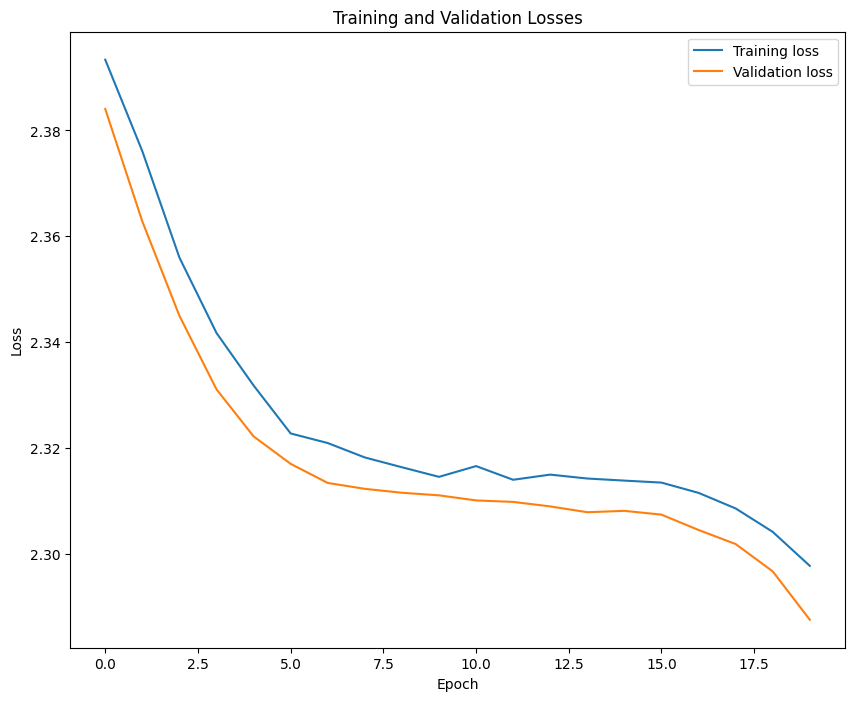

In [11]:
#plot the training and validation losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
print('Validation Accuracy')
testVal(val_loader, model)

Validation Accuracy
Got 36 / 152 correct (23.68)
